In [1]:
import stdpopsim
from math import floor
from copy import deepcopy

#### Species and demographic model currently available

In [2]:
# has to be available here: https://popsim-consortium.github.io/stdpopsim-docs/stable/catalog.html#
# currently from species, models from here: https://elifesciences.org/articles/54967 (2019)
# has to have time in generations
# has to have neglible migration
# has to have no recent population splits (define recent as 750 gens)
# has to have ploidy 1 or 2
specs = ['HomSap','DroMel','AraTha','PonAbe']
demos = {'HomSap':['Africa_1T12',
                   'Zigzag_1S14',
                   'OutOfAfrica_2T12'
         ],
         'DroMel':['OutOfAfrica_2L06','African3Epoch_1S16'],
         'AraTha':['African2Epoch_1H18','African3Epoch_1H18'],
         'PonAbe':['TwoSpecies_2L11']}

#### Main functions of notebook

In [3]:
def print_available_species():
    print(specs)
    return None
def print_available_demographic_models(species):
    print(demos[species])
    return None
def stdpopsim_catalog_grab_for_iSWEEP(species, demography, ploidy=2, maxgen=750):
    '''Grab species and demographic info from stdpopsim catalog
    
    Parameters
    ----------
    species : str
    demography : str
        Identifier for species, demographic model: 
        https://popsim-consortium.github.io/stdpopsim-docs/stable/catalog.html
    ploidy : int
        In case ploidy not available in catalog
    maxgen : int
        Maximum generation time
    
    Returns
    -------
    dict
        Enough info to format recent Ne
    '''
    # some checks
    assert type(ploidy) is int
    maxgen = int(float(maxgen))
    # bring in data
    spec = stdpopsim.get_species(species)
    gtim = spec.generation_time
    try:
        ploi = spec.ploidy
    except:
        ploi=ploidy
    init = spec.population_size
    demo = spec.get_demographic_model(demography)
    eves = demo.demographic_events
    conf = demo.population_configurations
    size = [pop.initial_size for pop in conf]
    grow = [pop.growth_rate for pop in conf]
    pops = demo.populations
    pids = [pop.id for pop in pops]
    # times, sizes, and rates
    times = []
    grows = []
    inits = []
    for i in range(len(pids)):
        xcoord = [0]
        curves = [grow[i]]
        isizes = [size[i]]
        thesee = [d for d in eves if d.type == 'population_parameters_change']
        thesee = [d for d in thesee if d.population == i]
        xcoord += [d.time for d in thesee]
        curves += [d.growth_rate for d in thesee]
        isizes += [d.initial_size for d in thesee]
        ctr = 0
        for x in xcoord:
            if x <= maxgen:
                ctr += 1
        xcoord = xcoord[:ctr]
        curves = curves[:ctr]
        isizes = isizes[:ctr]
        times.append(xcoord)
        grows.append(curves)
        inits.append(isizes)
    # output
    relv = {'Species':species,
            'Model':demography,
            'GenerationTime':gtim,
            'Ploidy':ploi,
            'DefaultSize':init,
            'PopulationIDs':pids,
            'Sizes':inits,
            'Growths':grows,
            'Times':times
           }
    return relv

In [4]:
def stdpopsim_format_Ne(relevant_dict, population_id = 0, maxgen=750):
    '''Format an Ne dictionary from relevant stdpopsim info
    
    Parameters
    ----------
    relevant_dict : dict
        From stdpopsim_catalog_grab_for_iSWEEP()
    population_id : int
    
    Returns
    -------
    dict
        Effective population sizes
    '''
    d = deepcopy(relevant_dict)
    szs = d['Sizes'][population_id]
    grs = d['Growths'][population_id]
    tms = d['Times'][population_id]
    assert len(tms)==len(grs)
    assert len(grs)==len(szs)
    tms.append(maxgen+1)
    st = 0
    curr = 0
    sz = szs[curr]
    gr = grs[curr]
    tm = tms[curr+1]
    Ne = dict()
    val = floor(sz)
    Ne[st] = val
    st += 1
    while st < maxgen:
        if st > tm:
            curr += 1
            sz = szs[curr]
            gr = grs[curr]
            tm = tms[curr+1]
        sca = 1 / (1 + gr)
        val = val * sca
        Ne[st] = val
        st += 1
    Ne = {key:floor(val) for key, val in Ne.items()}
    return Ne

In [16]:
def fill_Ne(Ne):
    '''Fill in effective sizes for non-specified generations
    
    Parameters
    ----------
    Ne : dict
        Effective population sizes
    
    Returns
    -------
    dict
        Modified Ne dictionary
    '''
    assert min(Ne.keys())==0
    Me=deepcopy(Ne)
    values=list(Ne.values())
    keys=list(Ne.keys())
    keys=sorted(keys,reverse=True)
    maxkey=max(keys)
    k = 0
    j = 1
    while j <= maxkey:
        prev = values[k]
        try:
            Me[j]
            k += 1
        except KeyError:
            Me[j] = prev
        j += 1
    return dict(sorted(Me.items(),key=lambda x:x[0]))

def write_Ne(Ne, output_file):
    with open(output_file, 'w') as f:
        f.write('GEN\tNE\n')
        for k in Ne.keys():
            f.write(str(k)); f.write('\t'); f.write(str(Ne[k])); f.write('\n')
    return None

#### Some manual entries

In [6]:
# manual entry (inbred cows)
# https://popsim-consortium.github.io/stdpopsim-docs/stable/catalog.html#sec_catalog_BosTau
# visited 2/12/2023
holstein_Ne = dict()
holstein_Ne[0] = 90
holstein_Ne[3+1] = 120
holstein_Ne[6+1] = 250
holstein_Ne[12+1] = 350
holstein_Ne[18+1] = 1000
holstein_Ne[24+1] = 1500
holstein_Ne[154+1] = 2000
holstein_Ne[254+1] = 2500
holstein_Ne[454+1] = 3500
holstein_Ne[654+1] = 7000
holstein_Ne[1754+1] = 10000
holstein_Ne[2354+1] = 17000
holstein_Ne = fill_Ne(holstein_Ne)
write_Ne(holstein_Ne,'../auxillary/ne/holstein.ne')

In [18]:
# manual entry (baboons)
# https://popsim-consortium.github.io/stdpopsim-docs/stable/catalog.html#sec_catalog_PapAnu
# visited 2/12/2023
papio_Ne = dict()
papio_Ne[0] = 335505
papio_Ne[floor(243/11)+1] = 120758
papio_Ne[floor(5101/11)+1] = 51822
papio_Ne[floor(165305/11)+1] = 41841
papio_Ne = fill_Ne(papio_Ne)
write_Ne(papio_Ne,'../auxillary/ne/papio.ne')

#### Plotting (uncomment and select PNG file location)

In [8]:
import matplotlib.pyplot as plt

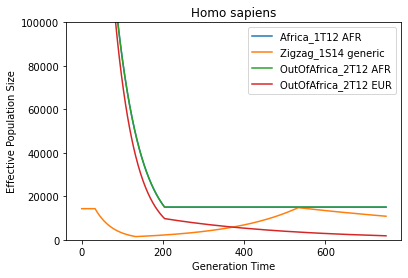

In [9]:
sp='HomSap'
for mo in demos[sp]:
    cat = stdpopsim_catalog_grab_for_iSWEEP(sp, mo)
    J = len(cat['PopulationIDs'])
    for j in range(J):
        Ne = stdpopsim_format_Ne(cat, j)
        keys = list(Ne.keys())
        vals = list(Ne.values())
        plt.plot(keys,vals,label=mo+' '+cat['PopulationIDs'][j])
plt.ylim(0,0.1e6)
plt.legend()
plt.xlabel('Generation Time')
plt.ylabel('Effective Population Size')
plt.title('Homo sapiens')
plt.rcParams.update({'font.size': 14})
# plt.savefig('homosapiens.png',dpi=300)

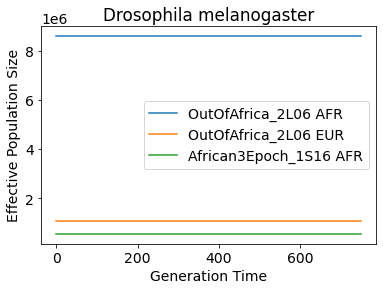

In [10]:
sp='DroMel'
for mo in demos[sp]:
    cat = stdpopsim_catalog_grab_for_iSWEEP(sp, mo)
    J = len(cat['PopulationIDs'])
    for j in range(J):
        Ne = stdpopsim_format_Ne(cat, j)
        keys = list(Ne.keys())
        vals = list(Ne.values())
        plt.plot(keys,vals,label=mo+' '+cat['PopulationIDs'][j])
# plt.ylim(0,0.1e6)
plt.legend()
plt.xlabel('Generation Time')
plt.ylabel('Effective Population Size')
plt.title('Drosophila melanogaster')
plt.rcParams.update({'font.size': 14})
# plt.savefig('drosophila.png',dpi=300)

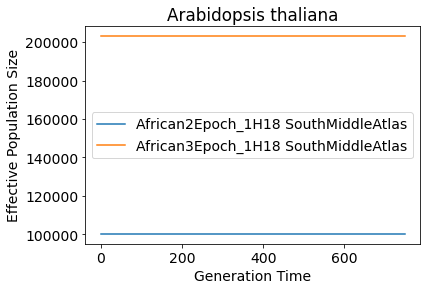

In [11]:
sp='AraTha'
for mo in demos[sp]:
    cat = stdpopsim_catalog_grab_for_iSWEEP(sp, mo)
    J = len(cat['PopulationIDs'])
    for j in range(J):
        Ne = stdpopsim_format_Ne(cat, j)
        keys = list(Ne.keys())
        vals = list(Ne.values())
        plt.plot(keys,vals,label=mo+' '+cat['PopulationIDs'][j])
# plt.ylim(0,0.1e6)
plt.legend()
plt.xlabel('Generation Time')
plt.ylabel('Effective Population Size')
plt.title('Arabidopsis thaliana')
plt.rcParams.update({'font.size': 14})
# plt.savefig('arabidopsis.png',dpi=300)

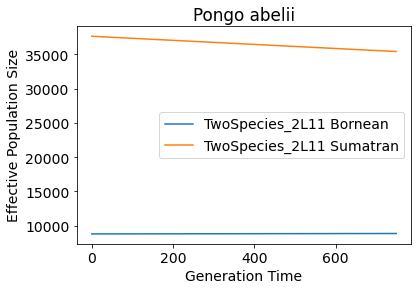

In [12]:
sp='PonAbe'
for mo in demos[sp]:
    cat = stdpopsim_catalog_grab_for_iSWEEP(sp, mo)
    J = len(cat['PopulationIDs'])
    for j in range(J):
        Ne = stdpopsim_format_Ne(cat, j)
        keys = list(Ne.keys())
        vals = list(Ne.values())
        plt.plot(keys,vals,label=mo+' '+cat['PopulationIDs'][j])
# plt.ylim(0,0.1e6)
plt.legend()
plt.xlabel('Generation Time')
plt.ylabel('Effective Population Size')
plt.title('Pongo abelii')
plt.rcParams.update({'font.size': 14})
# plt.savefig('pongo.png',dpi=300)

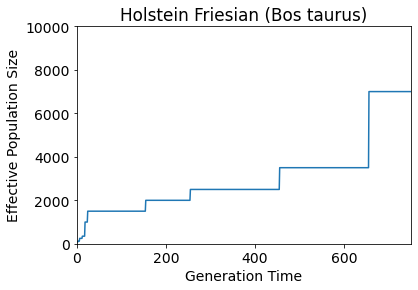

In [13]:
hNe = fill_Ne(holstein_Ne)
keys = list(hNe.keys())
vals = list(hNe.values())
plt.plot(keys,vals)
plt.xlim(0,750)
plt.ylim(0,10000)
plt.xlabel('Generation Time')
plt.ylabel('Effective Population Size')
plt.title('Holstein Friesian (Bos taurus)')
plt.rcParams.update({'font.size': 14})
# plt.savefig('holstein.png',dpi=300)

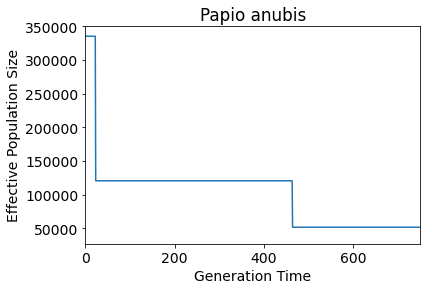

In [14]:
pNe = fill_Ne(papio_Ne)
keys = list(pNe.keys())
vals = list(pNe.values())
plt.plot(keys,vals)
plt.xlim(0,750)
# plt.ylim(0,10000)
plt.xlabel('Generation Time')
plt.ylabel('Effective Population Size')
plt.title('Papio anubis')
plt.rcParams.update({'font.size': 14})
# plt.savefig('papio.png',dpi=300)